In [51]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *

spark = SparkSession.builder \
         .master("spark://192.168.1.71:7077") \
         .appName("Project") \
         .config("spark.some.config.option", "some-value") \
         .getOrCreate()
        
sc = spark.sparkContext

# Chicago dataset
We used Crimes dataset from city of chicago portal and it contains many relevant information associated with each of the crime
that has occurred in chicago from year 2001 to till now. We are plotting the graph for number of times a particular crimes has 
occurred in chicago, what is the frequency of the crime in a year from 2001 to 2018.

In [52]:
#reading the csv file
df = spark.read.csv('Crimes.csv', header=True, inferSchema=True)

In [87]:
#df2 is 2.9 gb
#df2 = df.union(df)
print(df.printSchema())

root
 |-- ID: integer (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: boolean (nullable = true)
 |-- Domestic: boolean (nullable = true)
 |-- Beat: integer (nullable = true)
 |-- District: integer (nullable = true)
 |-- Ward: integer (nullable = true)
 |-- Community Area: integer (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: integer (nullable = true)
 |-- Y Coordinate: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Location: string (nullable = true)

None


In [37]:
#df3 is 5.8 gb
df3 = df2.union(df2)

In [47]:
df4 = df3.union(df3)
df4.count()

52807112

# Print RDD
For printing out the rdd on which map reduce according to the column has been performed

In [53]:
#For printing the rdd just paas the rdd object to print_rdd function
def print_rdd(output):
    for (word,count) in output.collect():
        print("%s: %i" % (word,count))
    

# Performing Map Reduce
Paas the dataframe to the below function and the column name which you want to reduce it. It will return the rdd object.

In [125]:
def map_reduce(df,x):
    crime_type = df.select(x)
    rddcrime = crime_type.rdd
    wordcounts= rddcrime.map(lambda w:(w,1)) \
        .reduceByKey(lambda a,b:a+b)
    return wordcounts

# Plotting RDD
Use below function to plot the rdd and paas the column name which you want in x and y axis while calling this function.

In [83]:
def plotting_graph(rdd,x,y): 
    #Plotting the graph for number of crimes and frequency
    schemaPeople = spark.createDataFrame(rdd)

    #renaming the column in dataframe
    schemaPeople = schemaPeople.withColumnRenamed('_1',x)
    schemaPeople = schemaPeople.withColumnRenamed('_2',y)

    schemaPanda = schemaPeople.toPandas()
    schemaPanda.plot.bar(x =x, y =y, colormap = 'summer',figsize=(10,7))

# Mapping Crime Type
Performed map reduce on Primary Type columns. It returns the number of times the particular crime has occured in chicago
from year 2001 to till now

In [70]:
rdd = map_reduce(df,'Primary Type')
print_rdd(rdd)

Row(Primary Type='INTIMIDATION'): 3832
Row(Primary Type='NON-CRIMINAL'): 145
Row(Primary Type='PUBLIC PEACE VIOLATION'): 47054
Row(Primary Type='BATTERY'): 1204701
Row(Primary Type='SEX OFFENSE'): 24392
Row(Primary Type='NON-CRIMINAL (SUBJECT SPECIFIED)'): 7
Row(Primary Type='CONCEALED CARRY LICENSE VIOLATION'): 187
Row(Primary Type='STALKING'): 3258
Row(Primary Type='MOTOR VEHICLE THEFT'): 309026
Row(Primary Type='OFFENSE INVOLVING CHILDREN'): 44061
Row(Primary Type='BURGLARY'): 381486
Row(Primary Type='KIDNAPPING'): 6579
Row(Primary Type='CRIMINAL TRESPASS'): 189822
Row(Primary Type='ARSON'): 10933
Row(Primary Type='OTHER OFFENSE'): 409517
Row(Primary Type='PUBLIC INDECENCY'): 154
Row(Primary Type='PROSTITUTION'): 67920
Row(Primary Type='ROBBERY'): 250499
Row(Primary Type='CRIM SEXUAL ASSAULT'): 26100
Row(Primary Type='INTERFERENCE WITH PUBLIC OFFICER'): 14433
Row(Primary Type='NON - CRIMINAL'): 38
Row(Primary Type='CRIMINAL DAMAGE'): 756105
Row(Primary Type='WEAPONS VIOLATION'): 676

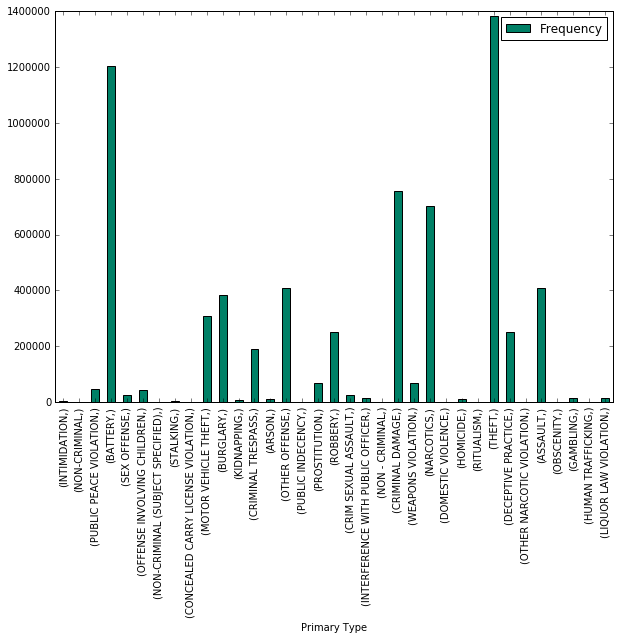

In [86]:
plotting_graph(rdd,'Primary Type','Frequency')

# Domestic Crimes
Percentage of the crimes that are domestic

In [61]:
df.filter(df['Domestic']==True).count()/df.count()*100

13.046469952759393

# Mapping Year
Plot for the crimes happening over the years

In [122]:
def map_reduce_year(df):
    crime_type = df.select('Year')
    rddcrime = crime_type.rdd
    wordcounts= rddcrime.map(lambda w:(w,1)) \
        .reduceByKey(lambda a,b:a+b)\
        .sortBy(lambda x: x[0])
    return wordcounts

In [92]:
rdd2 = map_reduce(df,'Year')
print_rdd(rdd2)

Row(Year=2003): 475929
Row(Year=2016): 268556
Row(Year=2012): 335862
Row(Year=2005): 453695
Row(Year=2009): 392632
Row(Year=2018): 85572
Row(Year=2014): 275006
Row(Year=2007): 436982
Row(Year=2011): 351708
Row(Year=2013): 306926
Row(Year=2017): 267078
Row(Year=2002): 486749
Row(Year=2015): 263715
Row(Year=2008): 427017
Row(Year=2004): 469373
Row(Year=2001): 485743
Row(Year=2010): 370261
Row(Year=2006): 448085


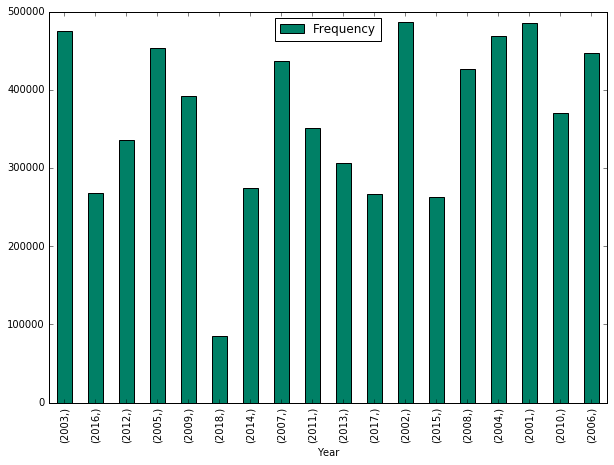

In [84]:
plotting_graph(rdd2,'Year','Frequency')


In [99]:
df_date = df.select('Date','Primary Type').show()

+--------------------+--------------------+
|                Date|        Primary Type|
+--------------------+--------------------+
|03/18/2015 07:44:...|             BATTERY|
|03/18/2015 11:00:...|       OTHER OFFENSE|
|03/18/2015 10:45:...|             BATTERY|
|03/18/2015 10:30:...|             BATTERY|
|03/18/2015 09:00:...|             ROBBERY|
|03/18/2015 10:00:...|             BATTERY|
|03/18/2015 11:00:...|             BATTERY|
|03/18/2015 09:35:...|             BATTERY|
|03/18/2015 10:09:...|           NARCOTICS|
|03/18/2015 09:25:...|             BATTERY|
|03/18/2015 09:30:...|     CRIMINAL DAMAGE|
|03/15/2015 04:10:...|       OTHER OFFENSE|
|03/18/2015 09:14:...|   WEAPONS VIOLATION|
|03/18/2015 10:50:...|             BATTERY|
|03/18/2015 10:31:...|               THEFT|
|03/18/2015 12:55:...|            BURGLARY|
|03/18/2015 08:00:...| MOTOR VEHICLE THEFT|
|03/18/2015 09:00:...|               THEFT|
|03/18/2015 10:56:...|PUBLIC PEACE VIOL...|
|03/18/2015 10:45:...|          

# Plotting Number of Crimes by Month
Using udf splitting date column and then returning month name according to the month number

In [118]:
from pyspark.sql.functions import udf
def date_format(SicCodes_Str):
        m = SicCodes_Str.split('/')[0]
        if m == '01':
            return 'Jan'
        if m == '02':
            return 'Feb'
        if m == '03':
            return 'March'
        if m == '04':
            return 'April'
        if m == '05':
            return 'May'
        if m == '06':
            return 'June'
        if m == '07':
            return 'July'
        if m == '08':
            return 'August'
        if m == '09':
            return 'Sep'
        if m == '10':
            return 'Oct'
        if m == '11':
            return 'Nov'
        if m == '12':
            return 'Dec'
  

udf_date = udf(date_format, StringType())


df = df.withColumn("Month",udf_date("Date"))

df.select('Date','Month').show()

+--------------------+-----+
|                Date|Month|
+--------------------+-----+
|03/18/2015 07:44:...|March|
|03/18/2015 11:00:...|March|
|03/18/2015 10:45:...|March|
|03/18/2015 10:30:...|March|
|03/18/2015 09:00:...|March|
|03/18/2015 10:00:...|March|
|03/18/2015 11:00:...|March|
|03/18/2015 09:35:...|March|
|03/18/2015 10:09:...|March|
|03/18/2015 09:25:...|March|
|03/18/2015 09:30:...|March|
|03/15/2015 04:10:...|March|
|03/18/2015 09:14:...|March|
|03/18/2015 10:50:...|March|
|03/18/2015 10:31:...|March|
|03/18/2015 12:55:...|March|
|03/18/2015 08:00:...|March|
|03/18/2015 09:00:...|March|
|03/18/2015 10:56:...|March|
|03/18/2015 10:45:...|March|
+--------------------+-----+
only showing top 20 rows



In [126]:
rdd3 = map_reduce(df,'Month')
print_rdd(rdd3)

Row(Month='Feb'): 463518
Row(Month='Jan'): 527797
Row(Month='August'): 599165
Row(Month='March'): 556954
Row(Month='May'): 585909
Row(Month='June'): 575915
Row(Month='Dec'): 482575
Row(Month='Oct'): 570047
Row(Month='April'): 558292
Row(Month='Sep'): 562538
Row(Month='Nov'): 512834
Row(Month='July'): 605345


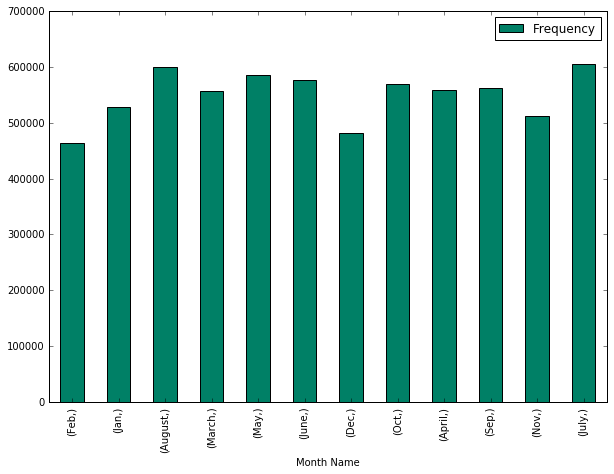

In [127]:
plotting_graph(rdd3,'Month Name','Frequency')

In [50]:
spark.stop()